# HMMER Tutorial - Exploring the Data

The HMMER tutorial should be completed or a copy of the data downloaded. The followind variable can be used to change the default location

In [1]:
data_dir = 'tutorial-hmmer-data/'

## Imports

In [65]:
from __future__ import print_function

#Python Standard Library
import glob
import pickle
import sys
import itertools

#External Dependencies (install via pip or anaconda)

# Check if running interactively or not
import matplotlib as mpl # http://matplotlib.org
# from:
# http://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
# and
# http://stackoverflow.com/questions/15455029/python-matplotlib-agg-vs-interactive-plotting-and-tight-layout
import __main__ as main
if hasattr(main, '__file__'):
    # Non interactive, force the use of Agg backend instead
    # of the default one
    mpl.use('Agg')

import numpy # http://www.numpy.org
import pandas # http://pandas.pydata.org
import seaborn # http://stanford.edu/~mwaskom/software/seaborn/
import scipy # http://www.scipy.org
import matplotlib.pyplot as plt 


#MGKit Import
from mgkit.io import gff, fasta
from mgkit.mappings import eggnog
import mgkit.counts, mgkit.taxon, mgkit.snps, mgkit.plots
import mgkit.snps
import mgkit.mappings.enzyme
import mgkit.net.uniprot
import mgkit.utils.dictionary
import mgkit.kegg

In [3]:
mgkit.logger.config_log()

In [4]:
mgkit.cite(sys.stdout)


 _|      _|    _|_|_|  _|    _|  _|    _|
 _|_|  _|_|  _|        _|  _|        _|_|_|_|
 _|  _|  _|  _|  _|_|  _|_|      _|    _|
 _|      _|  _|    _|  _|  _|    _|    _|
 _|      _|    _|_|_|  _|    _|  _|      _|_|


MGKit Version: 0.2.1

Rubino, F. and Creevey, C.J. (2014).
MGkit: Metagenomic Framework For The Study Of Microbial Communities.

Available at: http://figshare.com/articles/MGkit_Metagenomic_Framework_For_The_Study_Of_Microbial_Communities/1269288

[doi:10.6084/m9.figshare.1269288]



## Reads Data

In [5]:
# This file contains the SNPs information and it is the output
# of the snp_parser script
snp_data = pickle.load(open('{}snp_data.pickle'.format(data_dir), 'r'))

In [6]:
# Taxonomy needs to be download beforehand. It is loaded into an an
# instance of mgkit.taxon.UniprotTaxonomy. It is used in filtering
# data and to map taxon IDs to different levels in the taxonomy
taxonomy = mgkit.taxon.UniprotTaxonomy('{}mg_data/taxonomy.pickle'.format(data_dir))

INFO:mgkit.taxon:Loading taxonomy from file tutorial-hmmer-data/mg_data/taxonomy.pickle
2015-12-04 09:01:03,221 -    INFO - mgkit.taxon->load_data: Loading taxonomy from file tutorial-hmmer-data/mg_data/taxonomy.pickle


In [7]:
# Loads all annotations in a dictionary, with the unique ID (uid) as key
# and the mgkit.io.gff.Annotation instance that represent the line in the
# GFF file as value
annotations = {x.uid: x for x in gff.parse_gff('{}assembly.filt.cov.gff'.format(data_dir))}

INFO:mgkit.io.gff:Loading GFF from file (tutorial-hmmer-data/assembly.filt.cov.gff)
2015-12-04 09:02:55,375 -    INFO - mgkit.io.gff->parse_gff: Loading GFF from file (tutorial-hmmer-data/assembly.filt.cov.gff)


In [8]:
# Sample names
sample_names = {
    'I': "Influent",
    'B': "Buffering",
    'SA': "Secondary aeration",
    'PA': "Primary aeration",
    'SD': "Sludge digestion",
}

## Explore Diversity

Diversity can be analysed using pN/pS values. The data required to do this was produced in the tutorial by the snp_parser script. Here are some examples of how to calculate diversity estimates from the data outputted by snp_parser.
The complete toolset to map diversity estimates can be found in the mgkit.snps package, with the mgkit.snps.funcs.combine_sample_snps function building the final pandas DataFrame. As the use of the function requires the initialisation of different functions, a few easier to use ones are available in the mgkit.snps.conv_func module:
get_rank_dataframe
get_gene_map_dataframe
get_full_dataframe
get_gene_taxon_dataframe
The first is used to get diversity estimates for taxa, the second for genes/functions. The other two provides functionality to return estimates tied to both taxon and function.

In [9]:
# Sets the minimum coverage for an annotation to be
# included into the table (defaults to 4)
mgkit.consts.DEFAULT_SNP_FILTER['min_cov'] = 4

In [10]:
# To get diversity estimates for taxa *mgkit.snps.conv_func.get_rank_dataframe* can be used
# It is also imported and accesible from the *mgkit.snps* package
# ATTENTION: the lowest rank that can be used is *order*, since that's the level that was
# used when the profiles were created
pnps = mgkit.snps.get_rank_dataframe(snp_data, taxonomy, min_num=3, rank='order', index_type='taxon')

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 09:02:55,805 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 09:02:56,114 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 09:02:56,212 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 09:02:56,448 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 09:02:56,729 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


In [11]:
# Renaming the columns and rows
pnps = pnps.rename(
    columns=sample_names,
    index=lambda x: taxonomy[x].s_name.capitalize()
)

In [12]:
pnps.describe()

,Buffering,Influent,Primary aeration,Secondary aeration,Sludge digestion
count,60.000000,55.000000,60.000000,53.000000,48.000000
mean,0.439053,0.368924,0.434174,0.300415,0.277117
std,0.421404,0.421266,0.348828,0.340843,0.463352
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.120212,0.000000,0.156754,0.000000,0.000000
50%,0.377335,0.167667,0.389669,0.200464,0.096411
75%,0.652356,0.588091,0.703563,0.509091,0.340973
max,2.168022,1.481172,1.448138,1.447522,2.130008


In [13]:
pnps

,Buffering,Influent,Primary aeration,Secondary aeration,Sludge digestion
Coriobacteriales,0.000000,0.000000,NaN,0.000000,0.000000
Sphaerobacterales,0.000000,0.040271,0.000000,NaN,NaN
Bifidobacteriales,0.000000,0.000000,0.000000,0.000000,0.000000
Micrococcales,0.325792,NaN,0.216755,0.213321,0.310000
Corynebacteriales,0.779613,0.598788,0.813224,0.614930,0.436968
Pseudonocardiales,0.491324,0.000000,0.590002,0.487183,NaN
Streptomycetales,0.490956,1.022727,0.437736,0.622101,0.592287
Frankiales,NaN,0.000000,0.000000,0.000000,0.000000
Myxococcales,0.249625,NaN,0.185956,0.698357,0.338927
Synergistales,NaN,0.000000,NaN,0.000000,0.000000


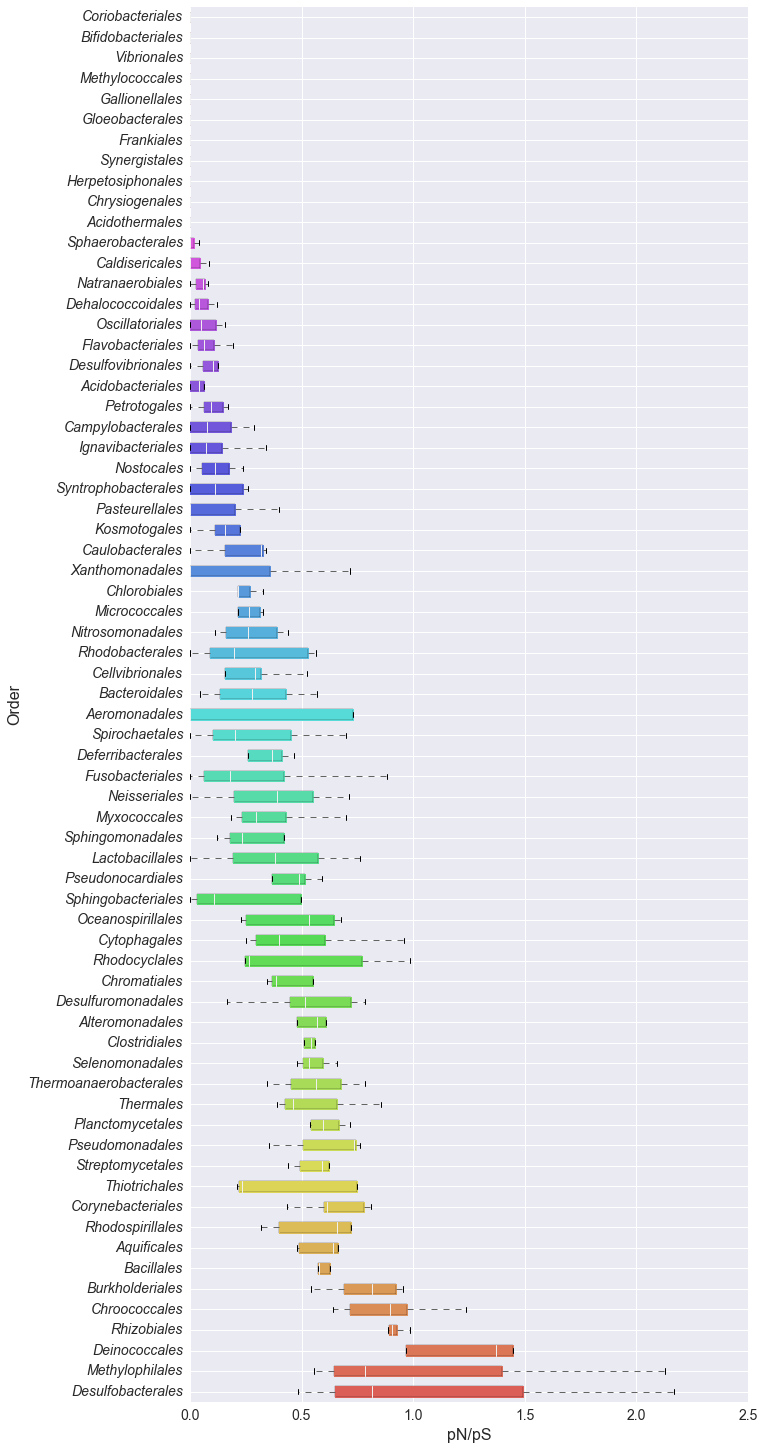

In [14]:
#sort the DataFrame to plot them by mean value
plot_order = pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(10, 25))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(pnps.index)))
    },
    box_vert=False
)

# Taxa names should be in italics
for text in ax.get_yticklabels():
    text.set_fontstyle('italic')
    
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('Order', fontsize=16)

### Phylum Level Diversity

Even if it was chosen the *Order* as rank for the profiles, a higher level represantation can be obtained.

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 09:02:58,684 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 09:02:59,868 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 09:03:00,318 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 09:03:01,534 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 09:03:03,031 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


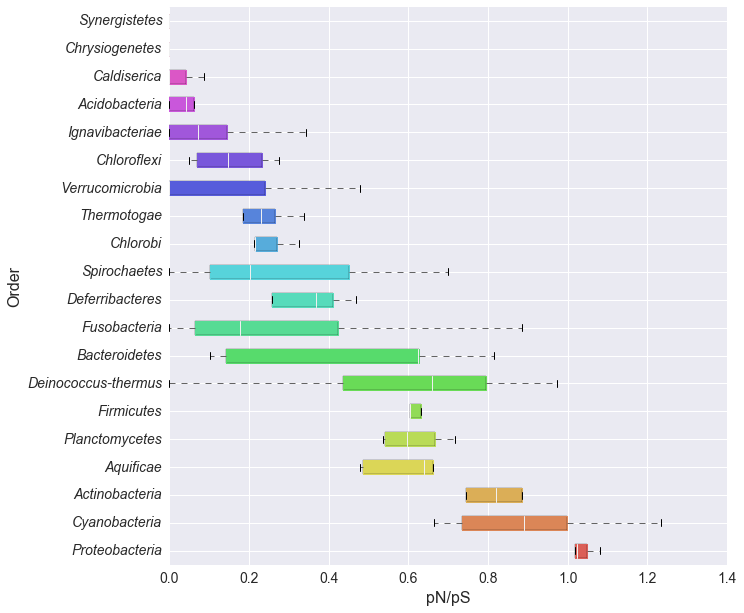

In [15]:
# The only difference is the *rank* chosen and the size of the plot
pnps = mgkit.snps.get_rank_dataframe(snp_data, taxonomy, min_num=3, rank='phylum', index_type='taxon')

pnps = pnps.rename(
    columns=sample_names,
    index=lambda x: taxonomy[x].s_name.capitalize()
)
#sort the DataFrame to plot them by mean value
plot_order = pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(10, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(pnps.index)))
    },
    box_vert=False
)
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('Phylum', fontsize=16)

# Taxa names should be in italics
for text in ax.get_yticklabels():
    text.set_fontstyle('italic')

## Using eggNOG and Functional Categories

### Loading eggNOG Data

In [16]:
eg = eggnog.NOGInfo()
# Just a few to speed up the analysis, but other can be used
# Should have been downloaded by the full tutorial script
eg.load_members('{}map_data/COG.members.txt.gz'.format(data_dir))
eg.load_members('{}map_data/NOG.members.txt.gz'.format(data_dir))
eg.load_funccat('{}map_data/COG.funccat.txt.gz'.format(data_dir))
eg.load_funccat('{}map_data/NOG.funccat.txt.gz'.format(data_dir))

INFO:mgkit.mappings.eggnog:Reading Members from tutorial-hmmer-data/map_data/COG.members.txt.gz
2015-12-04 09:03:04,057 -    INFO - mgkit.mappings.eggnog->load_members: Reading Members from tutorial-hmmer-data/map_data/COG.members.txt.gz
INFO:mgkit.mappings.eggnog:Reading Members from tutorial-hmmer-data/map_data/NOG.members.txt.gz
2015-12-04 09:03:16,505 -    INFO - mgkit.mappings.eggnog->load_members: Reading Members from tutorial-hmmer-data/map_data/NOG.members.txt.gz
INFO:mgkit.mappings.eggnog:Reading Functional Categories from tutorial-hmmer-data/map_data/COG.funccat.txt.gz
2015-12-04 09:03:23,638 -    INFO - mgkit.mappings.eggnog->load_funccat: Reading Functional Categories from tutorial-hmmer-data/map_data/COG.funccat.txt.gz
INFO:mgkit.mappings.eggnog:Reading Functional Categories from tutorial-hmmer-data/map_data/NOG.funccat.txt.gz
2015-12-04 09:03:23,686 -    INFO - mgkit.mappings.eggnog->load_funccat: Reading Functional Categories from tutorial-hmmer-data/map_data/NOG.funccat

### Download KO to eggNOG Mappings

To use functional categories a mapping from KO identifiers to eggNOG ones is needed. There's no direct path to get this, but one way is to get the mappings from KO to Uniprot identifiers and the mappings from the resulting Uniprot identifiers to eggNOG identifiers. In MGKit, the *net* package contains modules to use network resources. In particular, the *mgkit.net.uniprot* can be used to query Uniprot and also map identifiers.

In [17]:
# All gene_id properties of the annotations are put in a *set* to remove duplicates
ko_up = mgkit.net.uniprot.get_mappings(
    {annotation.gene_id for annotation in annotations.itervalues()}, 
    db_from='KO_ID', db_to='ID'
)
# While a complex expression, the *set* generation involves the iteration of all values from
# the *ko_up* dictionary to eliminate the duplicates
up_eg = mgkit.net.uniprot.get_mappings(
    set(itertools.chain(*(values for values in ko_up.itervalues()))), 
    db_from='ID', db_to='EGGNOG_ID'
)

After obtaining the two dictionaries in the correct order, a mapping dictionary can be produced with the *mgkit.utils.dictionary.combine_dict* function. This will produce a direct KO to eggNOG identifiers map.

In [18]:
ko_eg_map = mgkit.utils.dictionary.combine_dict(ko_up, up_eg)

Since we now have the KO to eggNOG mapping, we can associate to each KO identifier, the functional categories

In [19]:
#Build mapping KO IDs -> eggNOG functional categories
fc_map = {
    # notice that we use the *ko_eg_map*
    annotation.gene_id: eg.get_nogs_funccat(ko_eg_map[annotation.gene_id])
    for annotation in annotations.itervalues()
}

#### Saving the Mappings

It is possible to store the mapping we saved in the GFF with the following

In [20]:
# This will add the mappings to the annotations
for annotation in annotations.itervalues():
    annotation.set_mapping('eggnog', ko_eg_map[annotation.gene_id])

In [21]:
# And they are now available
annotations[annotations.keys()[0]].get_mapping('eggnog')

['COG1251',
 'ENOG4108IB8',
 'ENOG4107QS0',
 'ENOG4107QWN',
 'ENOG4107SJS',
 'COG0155',
 'ENOG4107RZH',
 'ENOG4107TEW',
 'ENOG4108JV3',
 'COG0446',
 'ENOG4108EQM',
 'ENOG4108I5Y',
 'ENOG4105WZK',
 'ENOG4108IFG',
 'COG2146',
 'ENOG4108IKH',
 'arCOG01070',
 'ENOG4107QZF',
 'ENOG4108IBF',
 'ENOG4108FJS']

In [22]:
# The GFF file needs to be saved
with open('{}assembly.filt.cov.eggnog.gff'.format(data_dir), 'w') as fh:
    for annotation in annotations.itervalues():
        annotation.to_file(fh)

In [23]:
# You can notice that the *map_EGGNOG* attribute was added to disk
print(open("{}assembly.filt.cov.eggnog.gff".format(data_dir)).readline())

2cd7ed88-d785-4c29-bcfa-f09c87d572bd	HMMER	gene	12	794	3.2e-30	-	2	B_cov="6";I_cov="0";PA_cov="7";SA_cov="3";SD_cov="3";aa_from="212";aa_seq="KNNIEVIMGSAKFTAPGKLSVELNDGGTEEVEAADVILATGAQPMIIPGMEPDGEKVLEYSQAIMLENLPASAVIIGGGAIGCEFATVWSAYGVEVHIVEMLPHLMPTEDDEAANELQKAFAKRGVKVHAGSKVKSVTKTETGTEVLLEGEGGEEKLAADITLVAVGFRPNSKDLGLEELGVEMDRRGFVQVDDRMATNVKGLWAIGDVTGQLLLAHVASAQGIVCAENIAGVETITLDYTMMPRAVYSHPQVASFGYTEA";aa_to="472";bitscore="111.6";cov="14";db="CUSTOM";evalue="3.2e-30";exp_nonsyn="1748";exp_syn="601";frame="r2";gene_id="K00362";ko_description="nirB%3B nitrite reductase (NADH) large subunit %5BEC%3A1.7.1.15%5D";ko_pathway="ko00910";ko_pathway_names="Nitrogen metabolism";map_EGGNOG="COG1251%2CENOG4108IB8%2CENOG4107QS0%2CENOG4107QWN%2CENOG4107SJS%2CCOG0155%2CENOG4107RZH%2CENOG4107TEW%2CENOG4108JV3%2CCOG0446%2CENOG4108EQM%2CENOG4108I5Y%2CENOG4105WZK%2CENOG4108IFG%2CCOG2146%2CENOG4108IKH%2CarCOG01070%2CENOG4107QZF%2CENOG4108IBF%2CENOG4108FJS";name="K00362_186802_clostridiales-nr";reviewed="Fa

### Create FC DataFrame

In [24]:
eg_pnps = mgkit.snps.get_gene_map_dataframe(snp_data, taxonomy, min_num=3, gene_map=fc_map, index_type='gene')

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 09:06:00,354 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 09:06:03,117 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 09:06:03,984 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 09:06:06,398 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 09:06:09,475 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


In [25]:
# Renames rows/columns
eg_pnps = eg_pnps.rename(
    columns=sample_names,
    index=eggnog.EGGNOG_CAT
)

In [26]:
eg_pnps.describe()

,Buffering,Influent,Primary aeration,Secondary aeration,Sludge digestion
count,12.000000,10.000000,12.000000,12.000000,12.000000
mean,0.705455,0.575509,0.659429,0.729560,0.549985
std,0.226856,0.462371,0.252799,0.251077,0.387537
min,0.198203,0.000000,0.186021,0.276498,0.119653
25%,0.608175,0.142835,0.588696,0.656642,0.148360
50%,0.705418,0.680306,0.733818,0.793950,0.636897
75%,0.882954,0.982550,0.844552,0.919806,0.873286
max,0.979928,1.092022,0.907965,0.992486,1.122793


In [27]:
eg_pnps

,Buffering,Influent,Primary aeration,Secondary aeration,Sludge digestion
Energy production and conversion,0.930722,0.962269,0.884856,0.908775,0.865246
Amino acid transport and metabolism,0.979928,0.989311,0.907965,0.975269,0.897406
Carbohydrate transport and metabolism,0.710614,0.040148,0.744589,0.752744,1.122793
Coenzyme transport and metabolism,0.700223,0.925447,0.723048,0.733340,0.732289
Transcription,0.506365,NaN,0.186021,0.835155,0.119653
"Translation, ribosomal structure and biogenesis",0.642112,0.142835,0.611148,0.276498,0.148360
"Replication, recombination and repair",0.642112,0.142835,0.611148,0.276498,0.148360
"Posttranslational modification, protein turnover, chaperones",0.506365,NaN,0.186021,0.835155,0.119653
"Secondary metabolites biosynthesis, transport and catabolism",0.198203,0.000000,0.521338,0.705336,0.150254
Inorganic ion transport and metabolism,0.875120,1.092022,0.890054,0.992486,0.920110


#### Plot the Distributions

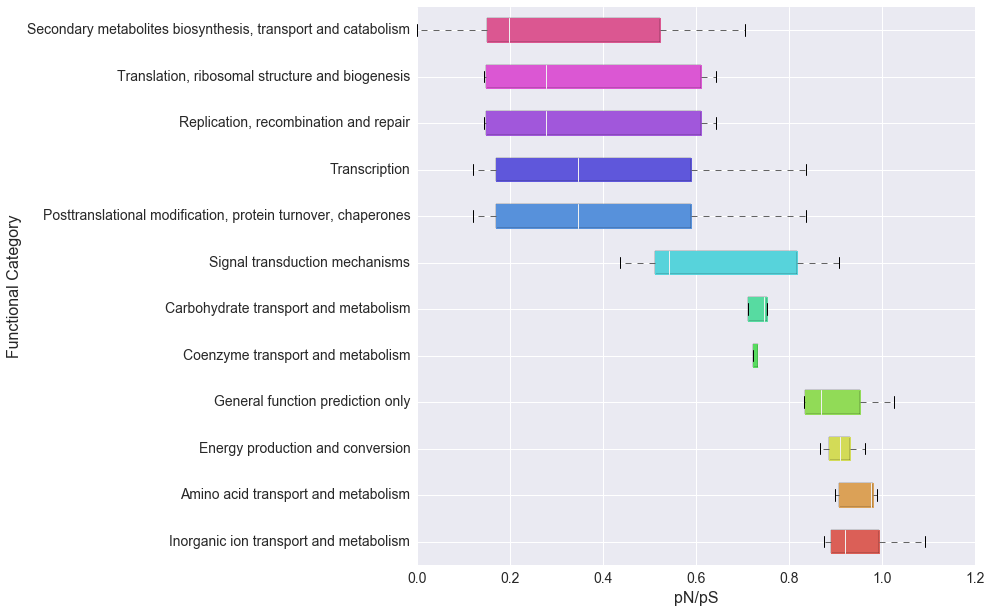

In [28]:
#sort the DataFrame to plot them by mean value
plot_order = eg_pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(10, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    eg_pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(eg_pnps.index)))
    },
    box_vert=False
)
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('Functional Category', fontsize=16)

#### Plot Distributions as KDE

Some better profiling can be found using the a KDE (Kernel Density Estimation). Seaborn makes it easy to plot it and it is easy to see that the Influent (first part) and Sludge digestion (last part) have a wider distribution of diversity estimates.

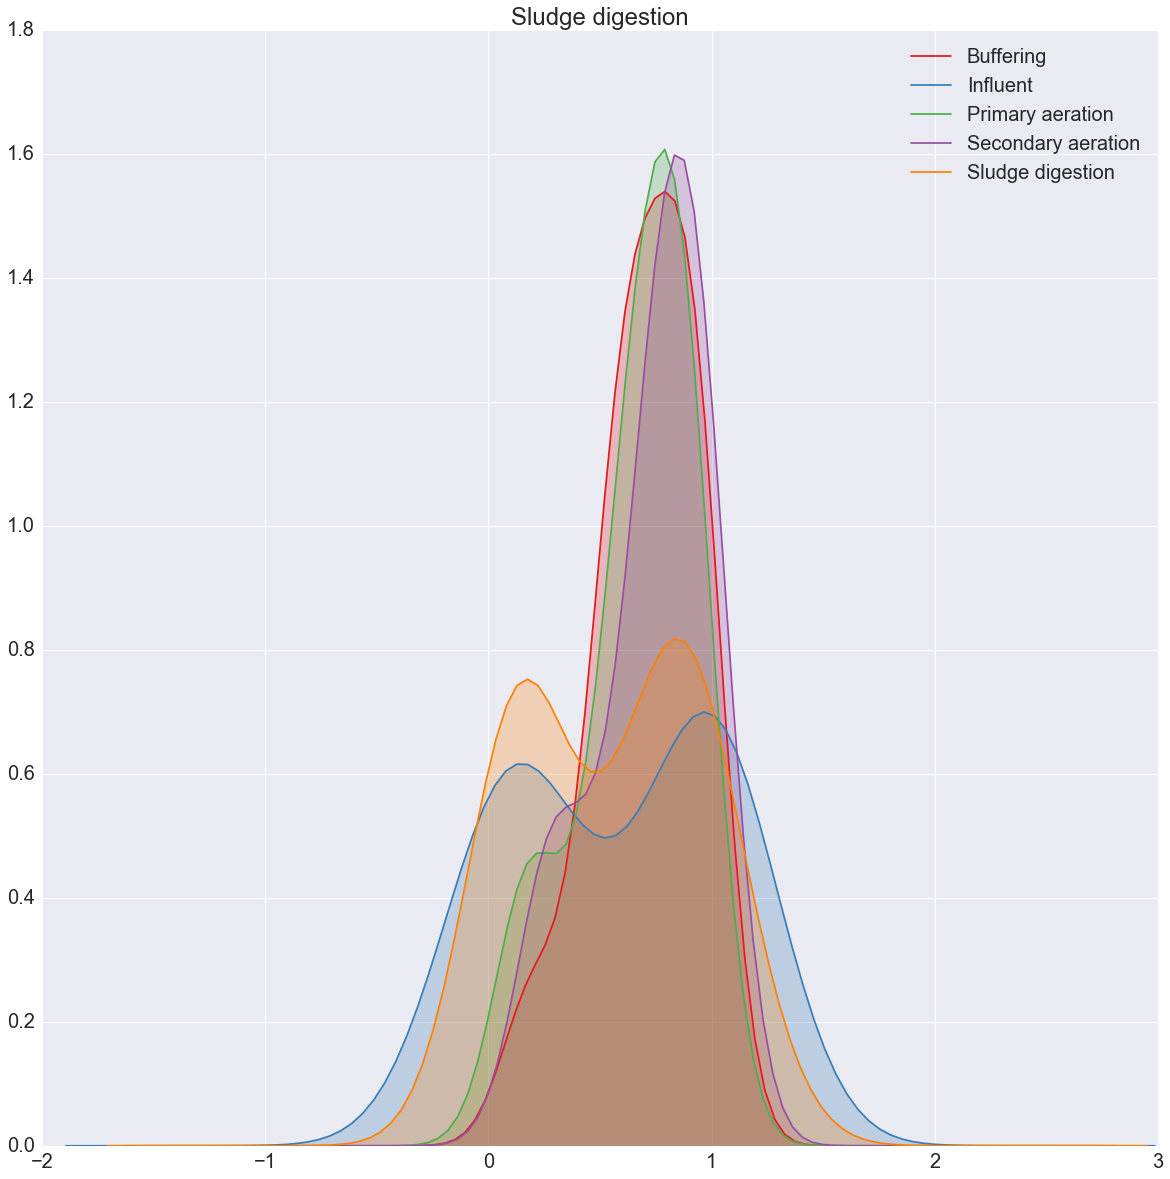

In [41]:
fig, ax = mgkit.plots.get_single_figure(figsize=(20, 20))

seaborn.set(font_scale=2)

for figid, (sample, color) in enumerate(zip(eg_pnps.columns, seaborn.color_palette('Set1', len(eg_pnps.columns)))):
    seaborn.kdeplot(eg_pnps[sample].dropna(), ax=ax, color=color, shade=True)
_ = ax.set_title(sample)

## Using Enzyme Classification

The enzyme classification mappings can be retrieved directly from KO identifiers using the Kegg REST API. MGKit provides a class that makes this easy to do.

In [66]:
# The first step is to instance the Kegg client class
kclient = mgkit.kegg.KeggClientRest()

In [70]:
# the *link_ids* is use to link any kind of identifiers within the Kegg DB. The first argument
# of the method is the target, in our case *ec*, for the enzyme classification and the second
# argument is the list of identifiers to map. To reduce the size of the query and because it would
# be redundant anyway, we can use a set for all annotations gene_id attribute we have.
ec_map = kclient.link_ids('ec', set(annotation.gene_id for annotation in annotations.itervalues()))

In [73]:
# You can see that for each KO identifier, a list of enzyme identifiers is returned
ec_map['K00260']

['1.4.1.2']

In [74]:
ec_pnps = mgkit.snps.get_gene_map_dataframe(snp_data, taxonomy, min_num=3, gene_map=ec_map, index_type='gene')

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 09:54:50,053 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 09:54:50,183 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 09:54:50,248 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 09:54:50,424 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 09:54:50,644 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


In [79]:
# The enzyme classification naming is verbose, so it's better not to rename the rows
ec_pnps = ec_pnps.rename(columns=sample_names)

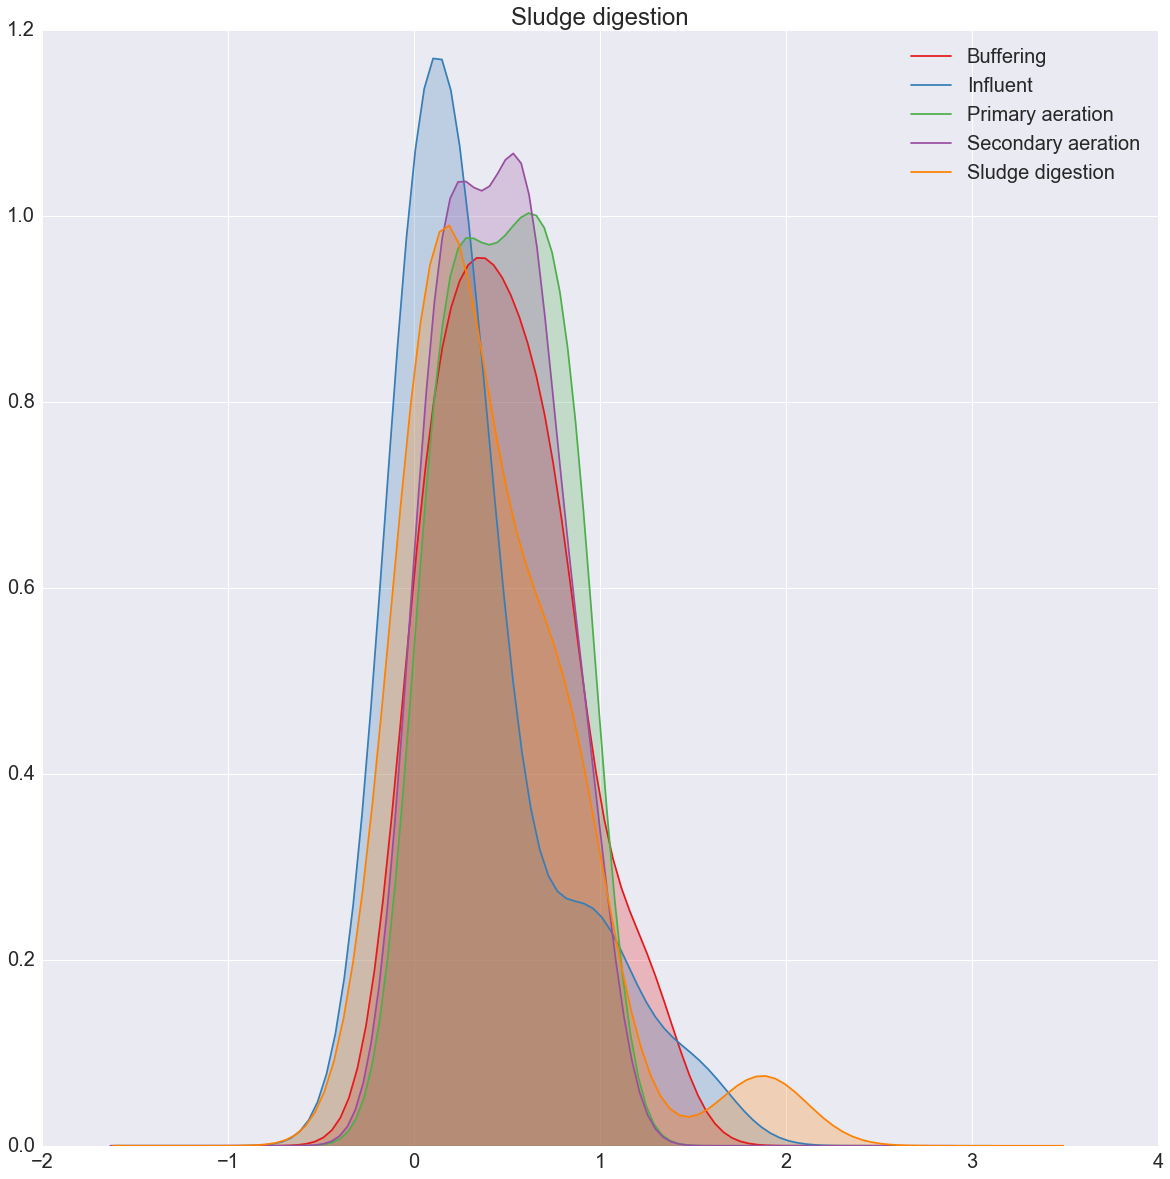

In [80]:
fig, ax = mgkit.plots.get_single_figure(figsize=(20, 20))

seaborn.set(font_scale=2)

for figid, (sample, color) in enumerate(zip(ec_pnps.columns, seaborn.color_palette('Set1', len(ec_pnps.columns)))):
    seaborn.kdeplot(ec_pnps[sample].dropna(), ax=ax, color=color, shade=True)
_ = ax.set_title(sample)

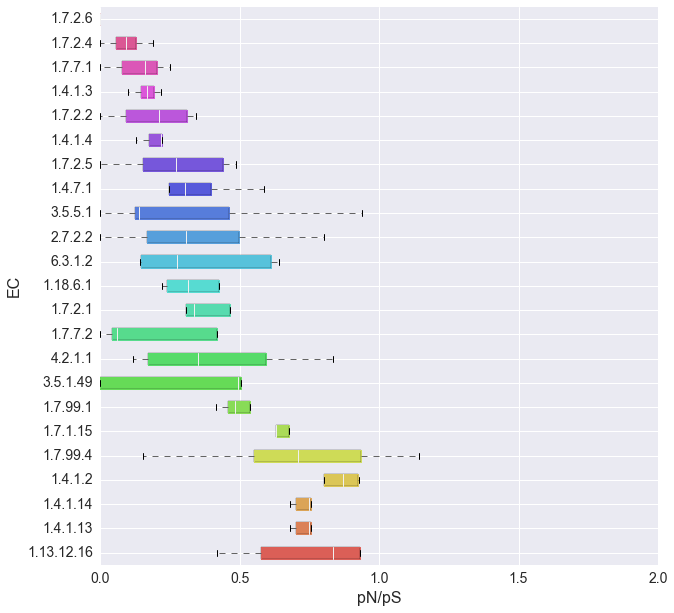

In [81]:
#sort the DataFrame to plot them by mean value
plot_order = ec_pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(10, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    ec_pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(ec_pnps.index)))
    },
    box_vert=False
)
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('EC', fontsize=16)

#### Adding full names to the enzymes

A dictionary with EC names (enzclass.txt) must be collected from expasy, at the following [address](ftp://ftp.expasy.org/databases/enzyme/enzclass.txt)

In [83]:
# The names of all EC identifiers can be obtained from expasy
ec_names = mgkit.mappings.enzyme.parse_expasy_file("{}map_data/enzclass.txt".format(data_dir))

In [114]:
reload(mgkit.mappings.enzyme)

<module 'mgkit.mappings.enzyme' from '/Users/francesco/dev/mgkit/mgkit/mappings/enzyme.py'>

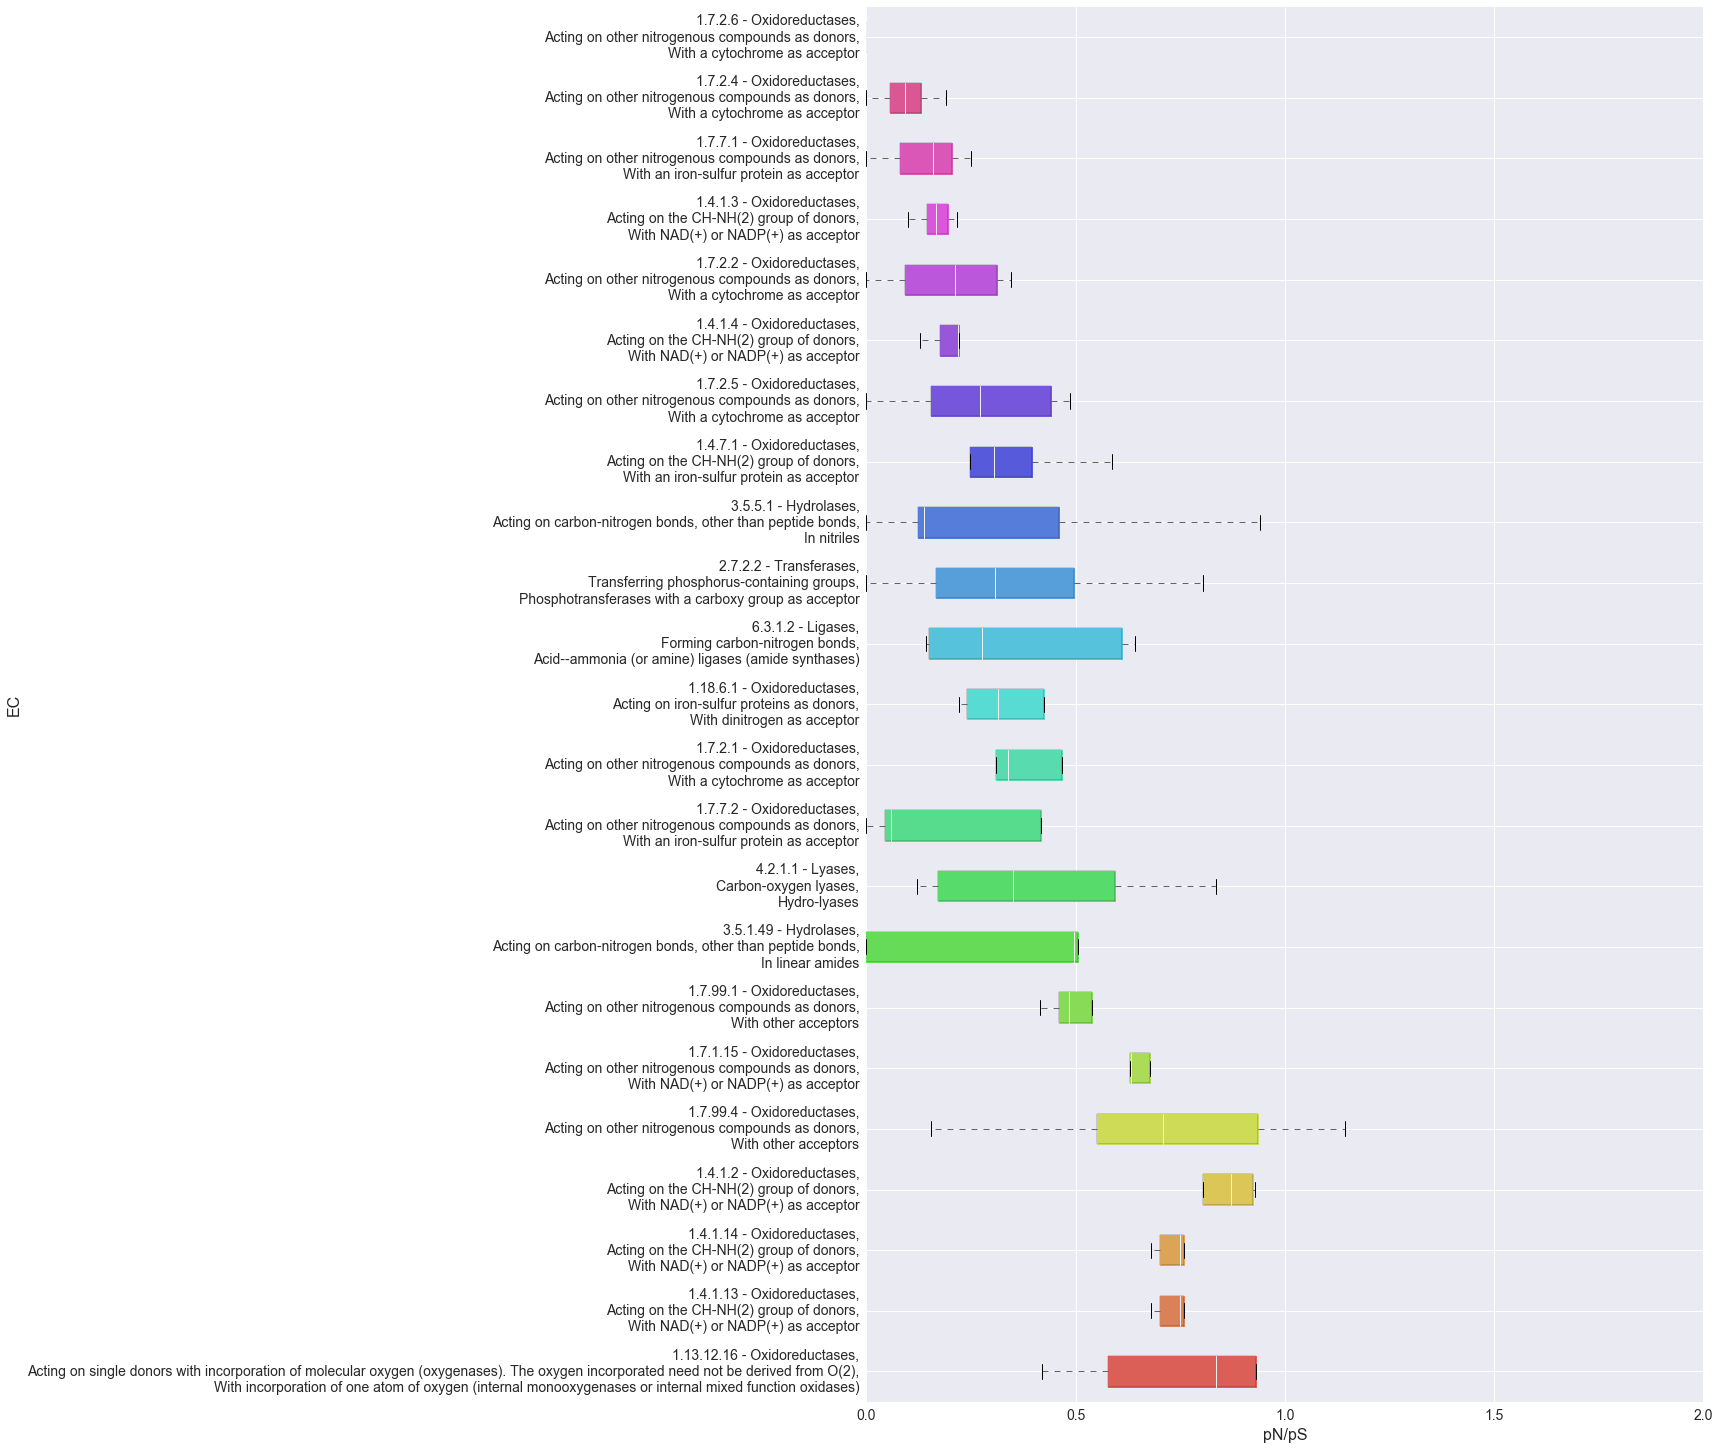

In [117]:
#sort the DataFrame to plot them by mean value
plot_order = ec_pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(15, 25))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    ec_pnps, 
    plot_order,
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(ec_pnps.index)))
    },
    box_vert=False,
    
    label_map={
        ec_id: "{} - {}".format(
            ec_id,
            mgkit.mappings.enzyme.get_enzyme_full_name(ec_id, ec_names, ',\n')
        )
        for ec_id in plot_order
    }
)
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('EC', fontsize=16)